In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/home/ram22/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Run first time to read excel and create pickled files
'''
migrationDB = pd.read_excel('../00_originalData/Case_Study_Data.xlsx', 'Migration', header=0)
demographicsDB = pd.read_excel('../00_originalData/Case_Study_Data.xlsx', 'Demographics', header=0)

migrationDB.columns = migrationDB.columns.str.lower()
migrationDB.set_index('new_mem_id', inplace=True, verify_integrity=True)

demographicsDB.columns = demographicsDB.columns.str.lower()
demographicsDB.set_index('new_mem_id', inplace=True, verify_integrity=True)

migrationDB.to_pickle('../02_createdData/migrationDB.pickle')
demographicsDB.to_pickle('../02_createdData/demographicsDB.pickle')
'''

"\nmigrationDB = pd.read_excel('../00_originalData/Case_Study_Data.xlsx', 'Migration', header=0)\ndemographicsDB = pd.read_excel('../00_originalData/Case_Study_Data.xlsx', 'Demographics', header=0)\n\nmigrationDB.columns = migrationDB.columns.str.lower()\nmigrationDB.set_index('new_mem_id', inplace=True, verify_integrity=True)\n\ndemographicsDB.columns = demographicsDB.columns.str.lower()\ndemographicsDB.set_index('new_mem_id', inplace=True, verify_integrity=True)\n\nmigrationDB.to_pickle('../02_createdData/migrationDB.pickle')\ndemographicsDB.to_pickle('../02_createdData/demographicsDB.pickle')\n"

In [3]:
# Second time onwards (once pickles are created)
migrationDB = pd.read_pickle('../02_createdData/migrationDB.pickle')
demographicsDB = pd.read_pickle('../02_createdData/demographicsDB.pickle')

In [4]:
migrationDB.head()
migrationDB.describe(include='all').loc['count':'last']
(pd.crosstab(index=migrationDB['source_country'], columns=migrationDB['destination_country'], 
            margins=True, normalize=True) * 100).round(2)

,week_beginning,source_country,source_region,destination_country,destination_region
new_mem_id,,,,,
420708,2016-08-07,United States,Greater San Diego Area,United States,Greater Los Angeles Area
108456,2016-12-11,United Kingdom,"London, United Kingdom",Australia,"Sydney Area, Australia"
435518,2016-09-11,United States,"Bloomington/Normal, Illinois",United States,Greater Chicago Area
263527,2016-01-10,United States,Greater Chicago Area,United States,Greater Boston Area
223585,2016-03-27,United States,Greater Chicago Area,United States,Washington D.C. Metro Area


,week_beginning,source_country,source_region,destination_country,destination_region
count,475316,475316,475316,475316,475316
unique,53,3,347,3,282
top,2016-07-31 00:00:00,United States,Greater New York City Area,United States,Greater New York City Area
freq,11460,429799,37000,430470,38088
first,2015-12-27 00:00:00,NaN,NaN,NaN,NaN
last,2016-12-25 00:00:00,NaN,NaN,NaN,NaN


destination_country,Australia,United Kingdom,United States,All
source_country,,,,
Australia,1.54,0.20,0.13,1.87
United Kingdom,0.20,6.97,0.54,7.70
United States,0.08,0.45,89.90,90.42
All,1.82,7.62,90.57,100.00


We will begin by making assumptions about the data generating process.
- the data is a random sample from all LinkedIn members during the one-year timeframe for these three countries where an individual moved across regions at least once
- the unit of observation is a separate individual-move event (across-regions)

Comments on random sample at country level:
- 90% of the source country values are from the USA and 91% of the  destination country values are to the USA. The large majority of moves are within-country, and most of these are withing the USA. The sample also shows net movement into the USA. 
- This imbalance could suggest:
  - this is not a random sample
  - structurally, the USA is composed of many markets with a low cost of migration; vs. the UK and Australia, which may have fewer labor markets (fewer cities) and higher costs for migration between these
  - LinkedIn members are not (equally?) representative of the (working age?) populations of these three countries, perhaps being more representative in the USA

Comments on unit of observation as individual-move event:
- vs separate indiviudals: while each obs has a different member id, conceptually a person can migrate more than once in a given year; but since there are no repeated id's, we assume that a second or further move would be a separate random pick and none of those were picked up

Other comments:
- weeks run from Sunday to Saturday
- the first day is complete (2015-12-27 is a Sunday)

In [5]:
demographicsDB.head()
demographicsDB.describe(include='all').loc['count':'freq']
demographicsDB['highest_degree_obtained'].value_counts(normalize=True, dropna=False)
demographicsDB['seniority'].value_counts(normalize=True, dropna=False)
demographicsDB['employer_industry_sector'].value_counts(normalize=True, dropna=False)
demographicsDB['position_function'].value_counts(normalize=True, dropna=False)

,highest_degree_obtained,seniority,employer_industry_sector,position_function
new_mem_id,,,,
1,doctor,Entry,Financial Services & Insurance,Information Technology
2,doctor,Partner,Architecture & Engineering,Business Development
3,bachelor,CXO,Retail & Consumer Products,Business Development
4,master,Entry,Technology - Hardware,Information Technology
5,master,Senior,Government/Education/Non-profit,Education


,highest_degree_obtained,seniority,employer_industry_sector,position_function
count,475316,475316,475316,475316
unique,4,11,14,26
top,bachelor,Entry,Government/Education/Non-profit,Engineering
freq,252952,220187,85999,53792


bachelor     0.532176
master       0.212048
associate    0.170564
doctor       0.085211
Name: highest_degree_obtained, dtype: float64

Entry       0.463243
Senior      0.309238
Manager     0.097365
Training    0.046384
Director    0.044377
VP          0.016587
CXO         0.012043
Owner       0.006947
Partner     0.003526
Unpaid      0.000280
unknown     0.000011
Name: seniority, dtype: float64

Government/Education/Non-profit    0.180930
Technology - Software              0.138276
Healthcare & Pharmaceutical        0.133135
Professional Services              0.127543
Financial Services & Insurance     0.101610
Retail & Consumer Products         0.076778
Architecture & Engineering         0.049668
Aero/Auto/Transport                0.048984
Media & Entertainment              0.046043
Technology - Hardware              0.026974
Manufacturing/Industrial           0.023687
Oil & Energy                       0.018743
Telecommunications                 0.014506
Staffing                           0.013122
Name: employer_industry_sector, dtype: float64

Engineering                         0.113171
Education                           0.086669
Sales                               0.083349
Operations                          0.077506
Research                            0.066556
Information Technology              0.066135
Business Development                0.062310
Healthcare Services                 0.052889
Finance                             0.048412
Community and Social Services       0.038345
Human Resources                     0.034264
Marketing                           0.031061
Program and Project Management      0.030990
Arts and Design                     0.029117
Media and Communication             0.027054
Accounting                          0.024891
Administrative                      0.022936
Consulting                          0.018935
Support                             0.017149
Quality Assurance                   0.013759
Legal                               0.012611
Military and Protective Services    0.011254
Entreprene

In [6]:
df = pd.merge(left=migrationDB, right=demographicsDB, 
              how='outer', left_index=True, right_index=True, indicator=True, validate='1:1')

df['_merge'].value_counts()
df.drop('_merge', inplace=True, axis=1)
df.to_pickle('../02_createdData/df.pickle')
del migrationDB, demographicsDB

both          475316
right_only         0
left_only          0
Name: _merge, dtype: int64

In [7]:
dfDates = df[['source_country', 'week_beginning', 'source_region']].groupby(
    ['source_country', 'week_beginning']).count()
dfDatesDomestic = df[['source_country', 'week_beginning', 'source_region']][
    df['source_country'] == df['destination_country']].groupby(
    ['source_country', 'week_beginning']).count()
dfDatesInternational = df[['source_country', 'week_beginning', 'source_region']][
    df['source_country'] != df['destination_country']].groupby(
    ['source_country', 'week_beginning']).count()

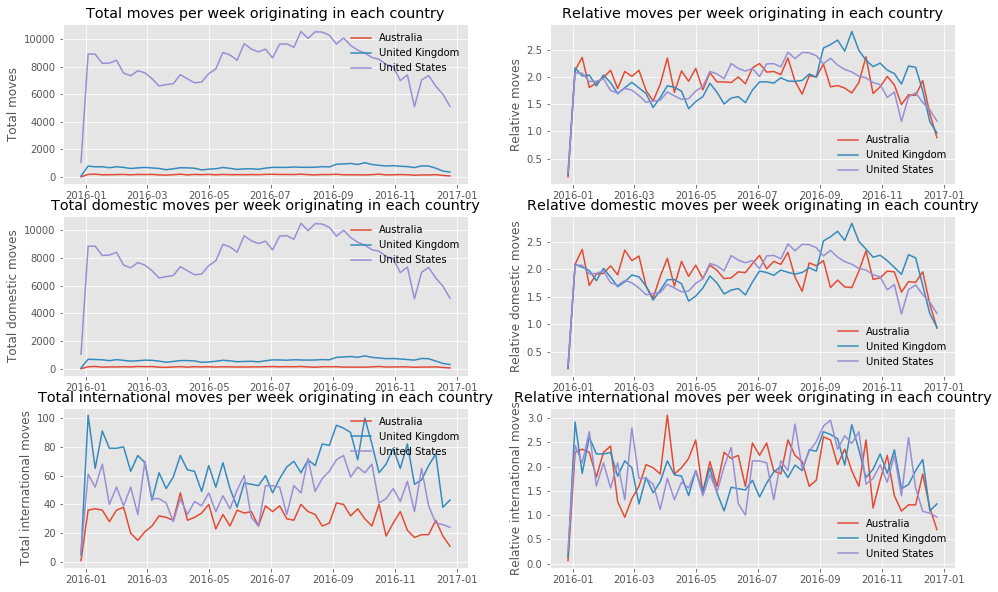

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(16,10))

dbList = [dfDates, dfDatesDomestic, dfDatesInternational]
titleList = [('Total moves per week originating in each country', 'Total moves'), 
            ('Relative moves per week originating in each country', 'Relative moves'),
            ('Total domestic moves per week originating in each country', 'Total domestic moves'),
            ('Relative domestic moves per week originating in each country', 'Relative domestic moves'),
            ('Total international moves per week originating in each country', 'Total international moves'),
            ('Relative international moves per week originating in each country', 'Relative international moves')]

for i in range(3):
    
    dates=dbList[i].unstack(level=0).index.to_pydatetime()
    ax[i, 0].plot(dates, dbList[i].unstack(level=0)['source_region'])
    ax[i, 0].set(title=titleList[i * 2][0], ylabel=titleList[i * 2][1])
    ax[i, 0].legend(dbList[i].unstack(level=0)['source_region'].columns, loc='upper right', frameon=False)
    
    ax[i, 1].plot(dates, dbList[i].unstack(level=0)['source_region'] \
                  * 100 / np.sum(dbList[i].unstack(level=0)['source_region']))
    ax[i, 1].set(title=titleList[i * 2 + 1][0], ylabel=titleList[i * 2 + 1][1])
    ax[i, 1].legend(dbList[i].unstack(level=0)['source_region'].columns, loc='lower right', frameon=False)

fig.savefig('../03_output/ts.png')
print();

- This opens a question about the first week of data: the values are a lot lower than the last week of the data, while both cover the end-of-year holidays
  - Would it make more sense to eliminate both endpoints as outliers?
  - Or re-base the time dimension (or eliminate it completely)?
- The dataset is dominated by moves in the USA
- Domestic moves dominate within each country
  - In fact, the US domestic flows dominate the dataset
- To try to understand trends in other countries, we could use separate analysis for each
- Domestic mobility within:
  - the USA raises around May, peaks around August - September, then drops again. Summer?
  - Australia, there is no obvious seasonality.
  - the UK, mobility seems to increase in late June or July and peak around October
- International mobility:
  - Low in all countries (vis-a-vis the domestic flows)
    - Too few observations to really think of modelling much at individual levels
    - Would it make sense to model all three together with a different intercept (bias) for each?
  - All three countries are within the same order of magnitude
  - In fact, the UK has more absolute international mobility than the USA
  - The UK's timeseries seems to have two modes (or rather, one trough)
  - Australia seems to have a weaker, but similar pattern
  - The USA seems not to.

In [9]:
seniorityOrder = ['Unpaid', 'Training', 'Entry', 'Senior', 'Manager', 'Director', 'VP', 'CXO',
       'Owner', 'Partner', 'unknown', 'All']
dfCounts = pd.crosstab(index=df['seniority'], columns=df['highest_degree_obtained'], 
                       margins=True, normalize=True)[['associate', 'bachelor', 'master', 'doctor', 'All']] * 100
dfCounts.round(2).reindex(index=seniorityOrder)

for i in ['Australia', 'United States', 'United Kingdom']:
    doWith = df[df['source_country'] == i]
    dfCounts = pd.crosstab(index=doWith['seniority'], columns=doWith['highest_degree_obtained'], 
                       margins=True, normalize=True)[['associate', 'bachelor', 'master', 'doctor', 'All']] * 100
    print(i + ':')
    dfCounts.round(2).reindex(index=seniorityOrder)

highest_degree_obtained,associate,bachelor,master,doctor,All
seniority,,,,,
Unpaid,0.01,0.02,0.00,0.00,0.03
Training,0.47,2.75,0.97,0.45,4.64
Entry,8.88,24.66,9.59,3.19,46.32
Senior,4.40,16.17,6.93,3.43,30.92
Manager,2.01,5.30,1.88,0.54,9.74
Director,0.70,2.24,1.01,0.49,4.44
VP,0.26,0.91,0.34,0.16,1.66
CXO,0.16,0.60,0.28,0.17,1.20
Owner,0.14,0.37,0.13,0.05,0.69


Australia:


highest_degree_obtained,associate,bachelor,master,doctor,All
seniority,,,,,
Unpaid,0.00,0.01,0.00,0.00,0.01
Training,0.06,1.12,0.43,0.12,1.73
Entry,1.19,26.12,10.16,2.33,39.79
Senior,0.93,22.66,10.60,3.22,37.42
Manager,0.44,8.35,3.56,0.57,12.92
Director,0.08,2.27,0.97,0.31,3.63
VP,0.09,1.03,0.56,0.12,1.81
CXO,0.03,0.78,0.45,0.08,1.34
Owner,0.03,0.62,0.19,0.06,0.90


United States:


highest_degree_obtained,associate,bachelor,master,doctor,All
seniority,,,,,
Unpaid,0.01,0.02,0.00,0.00,0.03
Training,0.51,2.79,0.96,0.46,4.72
Entry,9.69,24.78,9.53,3.23,47.23
Senior,4.75,15.51,6.60,3.35,30.21
Manager,2.16,5.02,1.74,0.52,9.44
Director,0.74,2.23,1.02,0.49,4.49
VP,0.28,0.91,0.33,0.16,1.67
CXO,0.17,0.60,0.27,0.16,1.20
Owner,0.15,0.35,0.11,0.05,0.67


United Kingdom:


highest_degree_obtained,associate,bachelor,master,doctor,All
seniority,,,,,
Unpaid,0.00,0.01,0.01,0.00,0.02
Training,0.11,2.59,1.26,0.43,4.39
Entry,1.29,22.88,10.07,2.98,37.23
Senior,1.12,22.35,9.84,4.36,37.68
Manager,0.60,7.84,3.15,0.86,12.45
Director,0.27,2.36,0.97,0.45,4.05
VP,0.07,0.88,0.34,0.16,1.44
CXO,0.07,0.61,0.34,0.25,1.27
Owner,0.03,0.54,0.27,0.08,0.92


In [10]:
(pd.crosstab(index=df['employer_industry_sector'], columns=df['seniority'], 
            margins=True, normalize=True) * 100).round(2)[seniorityOrder].sort_values(['All'])

seniority,Unpaid,Training,Entry,Senior,Manager,Director,VP,CXO,Owner,Partner,unknown,All
employer_industry_sector,,,,,,,,,,,,
Staffing,0.00,0.01,0.60,0.50,0.12,0.03,0.02,0.01,0.01,0.01,0.0,1.31
Telecommunications,0.00,0.03,0.63,0.50,0.19,0.06,0.02,0.01,0.00,0.00,0.0,1.45
Oil & Energy,0.00,0.07,0.83,0.63,0.21,0.07,0.03,0.03,0.01,0.00,0.0,1.87
Manufacturing/Industrial,0.00,0.07,1.07,0.64,0.38,0.09,0.06,0.03,0.02,0.00,0.0,2.37
Technology - Hardware,0.00,0.08,1.50,0.71,0.27,0.08,0.03,0.02,0.01,0.00,0.0,2.70
Media & Entertainment,0.00,0.26,2.21,1.15,0.50,0.27,0.08,0.06,0.06,0.01,0.0,4.60
Aero/Auto/Transport,0.00,0.19,2.41,1.36,0.62,0.17,0.07,0.04,0.02,0.01,0.0,4.90
Architecture & Engineering,0.00,0.20,2.49,1.41,0.51,0.17,0.07,0.05,0.05,0.01,0.0,4.97
Retail & Consumer Products,0.00,0.22,3.32,1.97,1.43,0.34,0.20,0.09,0.09,0.02,0.0,7.68


In [11]:
(df['source_region'].value_counts(normalize=True).head(10) * 100).round(2) 
(df['destination_region'].value_counts(normalize=True).head(10) * 100).round(2)
net = pd.concat([df['source_region'].value_counts(), df['destination_region'].value_counts()], 
                axis=1).fillna(0)
net = (net['destination_region'] - net['source_region']).sort_values(ascending=False)
net.head().astype(int)
net.tail().astype(int)

Greater New York City Area    7.78
Greater Los Angeles Area      4.85
San Francisco Bay Area        4.76
Washington D.C. Metro Area    4.15
Greater Chicago Area          3.90
Greater Boston Area           3.56
Dallas/Fort Worth Area        2.44
Greater Philadelphia Area     2.40
Greater Atlanta Area          2.33
London, United Kingdom        2.16
Name: source_region, dtype: float64

Greater New York City Area    8.01
San Francisco Bay Area        7.72
Washington D.C. Metro Area    5.38
Greater Los Angeles Area      4.92
London, United Kingdom        4.24
Greater Boston Area           3.77
Greater Chicago Area          3.56
Dallas/Fort Worth Area        3.40
Greater Seattle Area          3.27
Greater Atlanta Area          3.00
Name: destination_region, dtype: float64

San Francisco Bay Area        14064
London, United Kingdom         9887
Greater Seattle Area           7334
Washington D.C. Metro Area     5805
Dallas/Fort Worth Area         4565
dtype: int64

Norfolk, Virginia Area       -1314
Greater Philadelphia Area    -1380
Miami/Fort Lauderdale Area   -1473
Greater Chicago Area         -1577
Greater Pittsburgh Area      -1838
dtype: int64

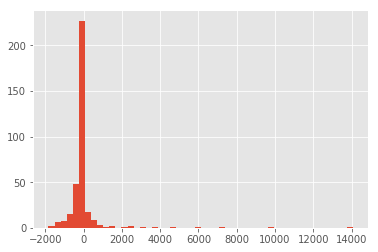

In [12]:
plt.hist(net, 50);

In [13]:
y = pd.concat([df['source_region'].value_counts(), df['destination_region'].value_counts()], 
                axis=1).fillna(0)
y = ( (y['destination_region'] - y['source_region']) /
        (y['destination_region'] + y['source_region'])).sort_values(ascending=False)
y.head(10).round(2)
y.tail(10).round(2)

Decatur, Illinois Area         1.00
Boise, Idaho Area              0.33
London, United Kingdom         0.33
Greater Seattle Area           0.31
San Francisco Bay Area         0.24
Fayetteville, Arkansas Area    0.24
Portland, Oregon Area          0.23
Manchester, United Kingdom     0.23
Greater Nashville Area         0.22
Greater Denver Area            0.21
dtype: float64

Kilmarnock, United Kingdom    -1.0
Kirkcaldy, United Kingdom     -1.0
Kokomo, Indiana Area          -1.0
Lancaster, United Kingdom     -1.0
Laredo, Texas Area            -1.0
Las Cruces, New Mexico Area   -1.0
Lincoln, United Kingdom       -1.0
Luton, United Kingdom         -1.0
Mackay Area, Australia        -1.0
Aberdeen, United Kingdom      -1.0
dtype: float64

In [14]:
net.loc['Decatur, Illinois Area']

net.loc['Aberdeen, United Kingdom']

52.0

-370.0

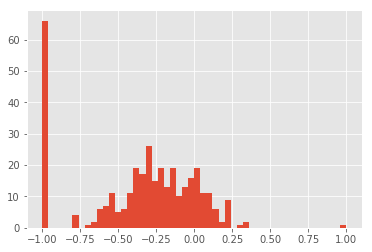

In [15]:
plt.hist(y, 50);

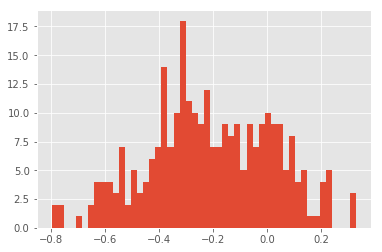

In [16]:
plt.hist(y[(y > -1) & (y < 1)], 50);

In [17]:
y = y[(y > -1) & (y < 1)]

x_w_dummies = pd.get_dummies(df.drop(['week_beginning', 'destination_country'], axis=1), 
                   {'source_country':'src',
                    'highest_degree_obtained':'deg', 'seniority':'sen', 
                    'employer_industry_sector':'ind', 'position_function':'pos'},
                  columns=['source_country', 
                           'highest_degree_obtained', 'seniority', 
                           'employer_industry_sector', 'position_function'])

x_destination = x_w_dummies.drop(['source_region', 'src_Australia', 'src_United Kingdom', 'src_United States'], axis=1
                       ).groupby('destination_region').sum()

x_source = x_w_dummies.groupby('source_region').sum()
x_destination['src_Australia'] = (x_source['src_Australia'] > 0).astype(int)
x_destination['src_United Kingdom'] = (x_source['src_United Kingdom'] > 0).astype(int)
x_destination['src_United States'] = (x_source['src_United States'] > 0).astype(int)

# This eliminates those that are only source or only dest... ie: value 1 or -1
x_commonIndex = x_source.index.intersection(x_destination.index)
x_source = x_source.reindex(index=x_commonIndex)
x_destination = x_destination.reindex(index=x_commonIndex)

# Denom can be zero if both are zero, so numerator will be zero too; thus change denom won't matter
x_denom = x_destination + x_source
x_denom[x_denom == 0] = 1 
x = (x_destination - x_source) / x_denom

x.describe()
y.describe()

,deg_associate,deg_bachelor,deg_doctor,deg_master,ind_Aero/Auto/Transport,ind_Architecture & Engineering,ind_Financial Services & Insurance,ind_Government/Education/Non-profit,ind_Healthcare & Pharmaceutical,ind_Manufacturing/Industrial,...,sen_Owner,sen_Partner,sen_Senior,sen_Training,sen_Unpaid,sen_VP,sen_unknown,src_Australia,src_United Kingdom,src_United States
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,...,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,-0.123792,-0.234045,-0.152959,-0.222260,-0.179505,-0.220002,-0.280955,-0.149531,-0.156552,-0.121348,...,-0.046379,-0.092186,-0.226884,-0.250569,-0.044853,-0.085709,0.000000,-0.035319,-0.211935,-0.746620
std,0.239839,0.245157,0.280911,0.248199,0.340307,0.324346,0.300979,0.219236,0.256192,0.384677,...,0.541774,0.595090,0.252648,0.351427,0.360602,0.482154,0.146385,0.184196,0.407479,0.430842
min,-1.000000,-0.824176,-0.903704,-0.851240,-1.000000,-1.000000,-0.901639,-0.790769,-0.829268,-1.000000,...,-1.000000,-1.000000,-0.842365,-1.000000,-1.000000,-1.000000,-1.000000,-0.999377,-0.999805,-0.999946
25%,-0.248157,-0.414062,-0.339806,-0.385417,-0.408000,-0.466667,-0.485714,-0.289720,-0.327014,-0.333333,...,-0.333333,-0.400000,-0.394737,-0.478261,0.000000,-0.333333,0.000000,0.000000,0.000000,-0.998049
50%,-0.106317,-0.258581,-0.153153,-0.230769,-0.145119,-0.228916,-0.313131,-0.145631,-0.146667,-0.111111,...,0.000000,0.000000,-0.240741,-0.250000,0.000000,-0.038108,0.000000,0.000000,0.000000,-0.994186
75%,0.032258,-0.035644,0.043689,-0.024074,0.047619,0.000000,-0.058824,0.003738,0.046154,0.120000,...,0.263158,0.076923,-0.027027,-0.022222,0.000000,0.142857,0.000000,0.000000,0.000000,-0.966102
max,0.500000,0.369290,0.666667,0.394895,1.000000,0.846154,0.411136,0.324731,0.481481,1.000000,...,1.000000,1.000000,0.366013,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000


count    281.000000
mean      -0.208537
std        0.231173
min       -0.797333
25%       -0.367089
50%       -0.222653
75%       -0.017861
max        0.329508
dtype: float64

In [18]:
x_reg = x.drop(['deg_bachelor', 'ind_Government/Education/Non-profit', 
                'pos_Engineering', 'sen_Entry', 'src_United States'], axis=1)
results = sm.OLS(y.sort_index(), sm.add_constant(x_reg.sort_index())).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     540.3
Date:                Fri, 01 Dec 2017   Prob (F-statistic):          6.15e-212
Time:                        00:44:31   Log-Likelihood:                 694.09
No. Observations:                 281   AIC:                            -1280.
Df Residuals:                     227   BIC:                            -1084.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


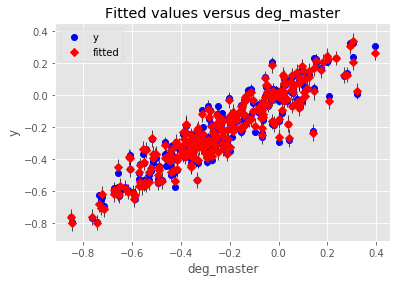

In [19]:
figModel, axModel = plt.subplots()
figModel = sm.graphics.plot_fit(results, 3, ax=axModel)

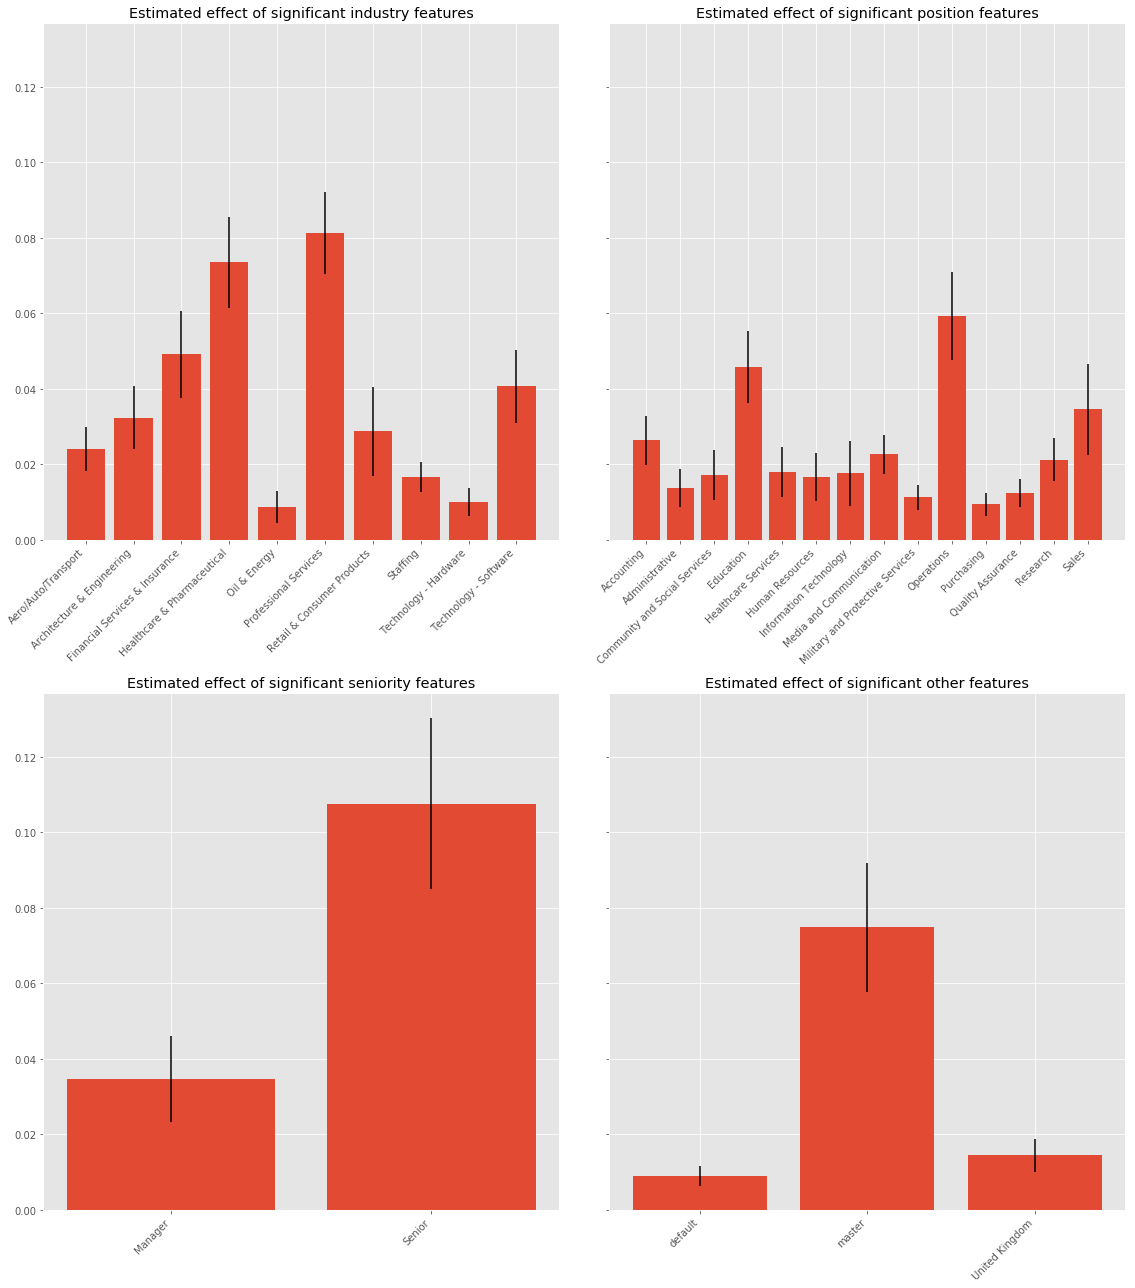

In [20]:
# Graph significant results
signif = results.params[results.pvalues <= 0.05]
std = results.bse[results.pvalues <= 0.05]

# Create "other" category
signif.index = signif.index.str.replace('const', 'src_default')
signif.index = signif.index.str.replace('deg_', 'src_')

xticks = signif.index.str.split('_')

figParam, axParam = plt.subplots(2, 2, sharey='all', figsize=(16, 18))

counter = 0

for g in [('ind', 'industry'), ('pos', 'position'), ('sen', 'seniority'), ('src', 'other')]:
    
    xticksNow = [i[1] for i in xticks if i[0] == g[0]]
    featureFilter = signif.index.str.find(g[0] + '_') == 0

    axParam[int(counter / 2), counter % 2].bar(np.arange(len(signif[featureFilter])),
                  signif[featureFilter], yerr = std[featureFilter])

    axParam[int(counter / 2), counter % 2].set(title='Estimated effect of significant ' + g[1] + ' features',
                                               xticks=np.arange(len(xticksNow)))

    axParam[int(counter / 2), counter % 2].set_xticklabels(xticksNow, rotation='45', ha='right', minor=False)
    
    counter += 1

plt.tight_layout()

figParam.savefig('../03_output/estimatedEffects.png')
print();

Default is 'deg_bachelor', 'ind_Government/Education/Non-profit', 'pos_Engineering', 'sen_Entry', 'src_United States'